In [ ]:
# Importa bibliotecas
import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import plotnine as p9

# Coleta dados
dados_brutos = pdr.get_data_fred(
  ["USREC", "GS10", "TB3MS", "PAYEMS", "CPIAUCSL"],
  start = "1975-01-01"
  )
dados_brutos.tail()

,USREC,GS10,TB3MS,PAYEMS,CPIAUCSL
DATE,,,,,
2024-01-01,0,4.06,5.22,157560,309.685
2024-02-01,0,4.21,5.24,157796,311.054
2024-03-01,0,4.21,5.24,158106,312.230
2024-04-01,0,4.54,5.24,158271,313.207
2024-05-01,0,4.48,5.25,158543,313.225


In [ ]:
# Realizar os tratamentos
dados_tratados = (
    dados_brutos
    .assign(
      slope_yield = dados_brutos["GS10"] - dados_brutos["TB3MS"],
      USREC = dados_brutos["USREC"].shift(-12).astype("category"),
      GS10_lag3 = dados_brutos["GS10"].shift(3),
      GS10_lag6 = dados_brutos["GS10"].shift(6),
      GS10_lag9 = dados_brutos["GS10"].shift(9),
      GS10_lag12 = dados_brutos["GS10"].shift(12)
      )
    .loc["1980":]
    .reset_index(names = "date")
    .dropna(subset = ["GS10", "TB3MS", "PAYEMS", "CPIAUCSL"])
    )
dados_tratados.tail()

,date,USREC,GS10,TB3MS,PAYEMS,CPIAUCSL,slope_yield,GS10_lag3,GS10_lag6,GS10_lag9,GS10_lag12
528,2024-01-01,NaN,4.06,5.22,157560,309.685,-1.16,4.80,3.90,3.46,3.53
529,2024-02-01,NaN,4.21,5.24,157796,311.054,-1.03,4.50,4.17,3.57,3.75
530,2024-03-01,NaN,4.21,5.24,158106,312.230,-1.03,4.02,4.38,3.75,3.66
531,2024-04-01,NaN,4.54,5.24,158271,313.207,-0.70,4.06,4.80,3.90,3.46
532,2024-05-01,NaN,4.48,5.25,158543,313.225,-0.77,4.21,4.50,4.17,3.57


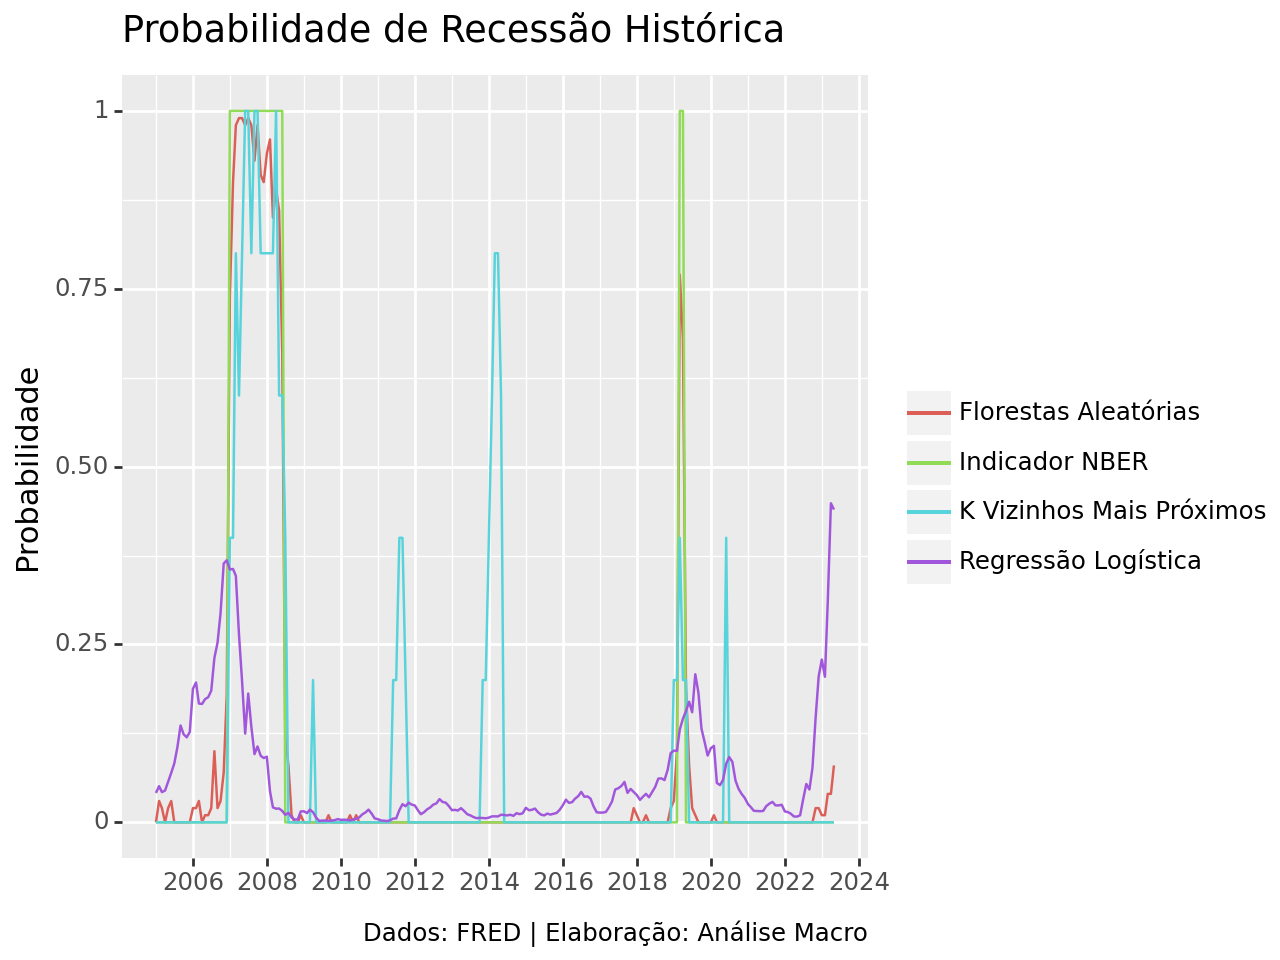

<Figure Size: (640 x 480)>

In [ ]:
# Modelo de Regressão Logística
lr_model = LogisticRegression(
  penalty = "l1",
  solver = "liblinear",
  max_iter = 1000
  )

# Modelo Random Forest
rf_model = RandomForestClassifier()

# Modelo k-Nearest Neighbors
knn_model = KNeighborsClassifier()

# Definir as variáveis preditoras e a variável de resposta
X = dados_tratados.dropna().drop(columns = ["USREC", "date"])
y = dados_tratados.dropna()["USREC"]

# Treinar os modelos
lr_model.fit(X, y)
rf_model.fit(X, y)
knn_model.fit(X, y)

# Obtendo as probabilidades previstas
lr_probs = lr_model.predict_proba(X)[:, 1]
rf_probs = rf_model.predict_proba(X)[:, 1]
knn_probs = knn_model.predict_proba(X)[:, 1]

# Criando um DataFrame para armazenar os dados de probabilidade
prob_data = pd.DataFrame({
    "Data": dados_tratados.dropna().date,
    "Indicador NBER": dados_tratados.dropna().USREC,
    "Regressão Logística": lr_probs,
    "Florestas Aleatórias": rf_probs,
    "K Vizinhos Mais Próximos": knn_probs
}).query("Data >= '2005-01-01'")

# Plotando o comportamento das probabilidades
(
  p9.ggplot(
    prob_data.melt(id_vars = "Data", var_name = "variavel", value_name = "valor")
    ) +
  p9.aes(x = "Data", y = "valor", color = "variavel") +
  p9.geom_line() +
  p9.scale_x_date(date_breaks = "2 years", date_labels = "%Y") +
  p9.labs(
    title = "Probabilidade de Recessão Histórica",
    y = "Probabilidade",
    x = "",
    color = "",
    caption = "Dados: FRED | Elaboração: Análise Macro"
    ) +
  p9.theme(
    legend_position = "right",
    legend_background = p9.element_blank()
    )
)

In [ ]:
# Dados obsevados omitidos no treinamento
dados_cortados = (
  dados_tratados
  .set_index("date")
  .query("USREC.isna()")
  .filter(items = X.columns.to_list(), axis = "columns")
)

# Perído de previsão
periodo_previsao = pd.date_range(
  start = dados_cortados.index.max() + pd.DateOffset(months = 1),
  end = dados_cortados.index.max() + pd.DateOffset(months = 12),
  freq = "MS"
  )

# Função para linearizar do último valor de col até o alvo por h períodos
def cenarizar(df, col, alvo, h = 11):
  resultado = pd.Series(
    [df[col].iloc[-1]] + ([np.nan] * h) + [alvo]
    ).interpolate()[1:]
  return resultado

# Cenário pessimista de previsão futuro
cenario_pessimista = pd.DataFrame(
  data = {
    "date": periodo_previsao,
    "GS10": cenarizar(dados_tratados, "GS10", 10),
    "TB3MS": cenarizar(dados_tratados, "TB3MS", 15),
    "PAYEMS": cenarizar(dados_tratados, "PAYEMS", 140000),
    "CPIAUCSL": cenarizar(dados_tratados, "CPIAUCSL", 350)
  }
).set_index("date")

# Cenário otimista de previsão futuro
cenario_otimista = pd.DataFrame(
  data = {
    "date": periodo_previsao,
    "GS10": cenarizar(dados_tratados, "GS10", 4),
    "TB3MS": cenarizar(dados_tratados, "TB3MS", 2.7),
    "PAYEMS": cenarizar(dados_tratados, "PAYEMS", 160000),
    "CPIAUCSL": cenarizar(dados_tratados, "CPIAUCSL", 275)
  }
).set_index("date")

# Cenário base de previsão futuro
cenario_base = (
  pd.concat([dados_tratados.query("date == date.max()")] * 12)
  .assign(date = periodo_previsao)
  .set_index("date")
  .drop("USREC", axis = "columns")
)

# Organiza tabelas de cenários
omitido_e_ult12 = pd.concat([
  (
    dados_tratados
    .set_index("date")
    .dropna()
    .tail(12)
    .filter(items = X.columns.to_list(), axis = "columns")
  ),
  dados_cortados
  ])

tabela_pessimista = (
  pd.concat([omitido_e_ult12, cenario_pessimista])
  .assign(
    slope_yield = lambda x: x["GS10"] - x["TB3MS"],
    GS10_lag3 = lambda x: x["GS10"].shift(3),
    GS10_lag6 = lambda x: x["GS10"].shift(6),
    GS10_lag9 = lambda x: x["GS10"].shift(9),
    GS10_lag12 = lambda x: x["GS10"].shift(12)
    )
  .dropna()
)
tabela_pessimista.tail()

,GS10,TB3MS,PAYEMS,CPIAUCSL,slope_yield,GS10_lag3,GS10_lag6,GS10_lag9,GS10_lag12
date,,,,,,,,,
2025-01-01,8.16,11.7500,146181.00,337.741667,-3.5900,6.78,5.40,4.54,4.06
2025-02-01,8.62,12.5625,144635.75,340.806250,-3.9425,7.24,5.86,4.48,4.21
2025-03-01,9.08,13.3750,143090.50,343.870833,-4.2950,7.70,6.32,4.94,4.21
2025-04-01,9.54,14.1875,141545.25,346.935417,-4.6475,8.16,6.78,5.40,4.54
2025-05-01,10.00,15.0000,140000.00,350.000000,-5.0000,8.62,7.24,5.86,4.48


In [ ]:
tabela_otimista = (
  pd.concat([omitido_e_ult12, cenario_otimista])
  .assign(
    slope_yield = lambda x: x["GS10"] - x["TB3MS"],
    GS10_lag3 = lambda x: x["GS10"].shift(3),
    GS10_lag6 = lambda x: x["GS10"].shift(6),
    GS10_lag9 = lambda x: x["GS10"].shift(9),
    GS10_lag12 = lambda x: x["GS10"].shift(12)
    )
  .dropna()
)
tabela_otimista.tail()

,GS10,TB3MS,PAYEMS,CPIAUCSL,slope_yield,GS10_lag3,GS10_lag6,GS10_lag9,GS10_lag12
date,,,,,,,,,
2025-01-01,4.16,3.5500,159514.333333,287.741667,0.6100,4.28,4.40,4.54,4.06
2025-02-01,4.12,3.3375,159635.750000,284.556250,0.7825,4.24,4.36,4.48,4.21
2025-03-01,4.08,3.1250,159757.166667,281.370833,0.9550,4.20,4.32,4.44,4.21
2025-04-01,4.04,2.9125,159878.583333,278.185417,1.1275,4.16,4.28,4.40,4.54
2025-05-01,4.00,2.7000,160000.000000,275.000000,1.3000,4.12,4.24,4.36,4.48


In [ ]:
tabela_base = (
  pd.concat([omitido_e_ult12, cenario_base])
  .assign(
    slope_yield = lambda x: x["GS10"] - x["TB3MS"],
    GS10_lag3 = lambda x: x["GS10"].shift(3),
    GS10_lag6 = lambda x: x["GS10"].shift(6),
    GS10_lag9 = lambda x: x["GS10"].shift(9),
    GS10_lag12 = lambda x: x["GS10"].shift(12)
    )
  .dropna()
)
tabela_base.tail()

,GS10,TB3MS,PAYEMS,CPIAUCSL,slope_yield,GS10_lag3,GS10_lag6,GS10_lag9,GS10_lag12
date,,,,,,,,,
2025-01-01,4.48,5.25,158543,313.225,-0.77,4.48,4.48,4.54,4.06
2025-02-01,4.48,5.25,158543,313.225,-0.77,4.48,4.48,4.48,4.21
2025-03-01,4.48,5.25,158543,313.225,-0.77,4.48,4.48,4.48,4.21
2025-04-01,4.48,5.25,158543,313.225,-0.77,4.48,4.48,4.48,4.54
2025-05-01,4.48,5.25,158543,313.225,-0.77,4.48,4.48,4.48,4.48


/usr/local/lib/python3.10/dist-packages/plotnine/geoms/geom_path.py:98: PlotnineWarning: geom_path: Removed 12 rows containing missing values.


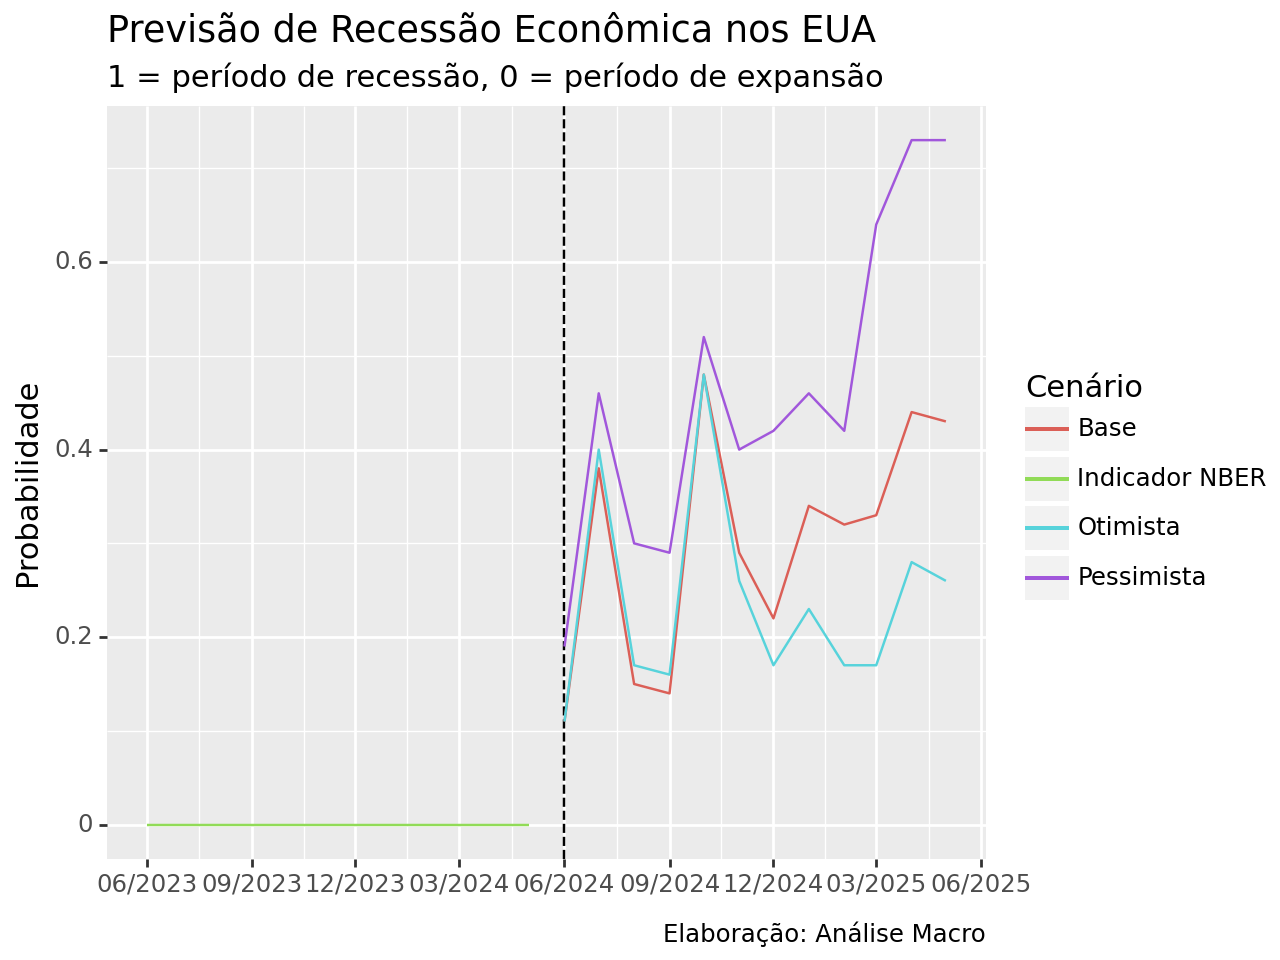

<Figure Size: (640 x 480)>

In [ ]:
# Previsão de probabilidade de recessão
previsao_pessimista = rf_model.predict_proba(tabela_pessimista)[:, 1]
previsao_otimista = rf_model.predict_proba(tabela_otimista)[:, 1]
previsao_base = rf_model.predict_proba(tabela_base)[:, 1]

# Criando um DataFrame para armazenar os dados de previsão
previsoes = (
  pd.DataFrame({
    "Data": tabela_pessimista.index,
    "Indicador NBER": (
      pd.concat([
        dados_brutos.query("index in @tabela_pessimista.index").USREC,
        pd.Series(
          np.nan,
          index = pd.date_range(
            dados_brutos.query("index in @tabela_pessimista.index").index.max() + pd.DateOffset(months = 1),
            periods = previsao_pessimista.shape[0] - 12,
            freq = "MS"
            )
          )
        ])
      ),
    "Pessimista": previsao_pessimista,
    "Base": previsao_otimista,
    "Otimista": previsao_base
  })
  .assign(
    Pessimista = lambda x: np.where(x.Data < periodo_previsao.min(), np.nan, x.Pessimista),
    Base = lambda x: np.where(x.Data < periodo_previsao.min(), np.nan, x.Base),
    Otimista = lambda x: np.where(x.Data < periodo_previsao.min(), np.nan, x.Otimista),
    )
  .melt(id_vars = "Data", var_name = "cenario", value_name = "valor")
)

# Visualização de dados
(
  p9.ggplot(previsoes) +
  p9.aes(x = "Data", y = "valor", color = "cenario") +
  p9.geom_vline(xintercept = periodo_previsao.min(), linetype = "dashed") +
  p9.geom_line() +
  p9.scale_x_date(date_breaks = "3 months", date_labels = "%m/%Y") +
  p9.labs(
    title = "Previsão de Recessão Econômica nos EUA",
    subtitle = "1 = período de recessão, 0 = período de expansão",
    y = "Probabilidade",
    x = "",
    color = "Cenário",
    caption = "Elaboração: Análise Macro"
    ) +
  p9.theme(
    legend_position = "right",
    legend_background = p9.element_blank()
    )
)